# Semantic Segmentation Demo

This is a notebook for running the benchmark semantic segmentation network from the the [ADE20K MIT Scene Parsing Benchchmark](http://sceneparsing.csail.mit.edu/).

The code for this notebook is available here
https://github.com/CSAILVision/semantic-segmentation-pytorch/tree/master/notebooks

It can be run on Colab at this URL https://colab.research.google.com/github/CSAILVision/semantic-segmentation-pytorch/blob/master/notebooks/DemoSegmenter.ipynb

### Environment Setup

First, download the code and pretrained models if we are on colab.

In [1]:
%%bash
# Colab-specific setup
# !(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

From https://github.com/CSAILVision/semantic-segmentation-pytorch
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


## Imports and utility functions

We need pytorch, numpy, and the code for the segmentation model.  And some utilities for visualizing the data.

In [19]:
# System libs
import cv2
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode

colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)
    PIL.Image.fromarray(pred_color).save("seg_colored.png")
    PIL.Image.fromarray(numpy.array(pred + 1, dtype=numpy.uint8)).save("pred.png")
    # cv2.imwrite("pred.png", pred + 1)
    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    display(PIL.Image.fromarray(im_vis).resize((512, 256)))

## Loading the segmentation model

Here we load a pretrained segmentation model.  Like any pytorch model, we can call it like a function, or examine the parameters in all the layers.

After loading, we put it on the GPU.  And since we are doing inference, not training, we put the model in eval mode.

In [20]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
# segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

## Load test data

Now we load and normalize a single test image.  Here we use the commonplace convention of normalizing the image to a scale for which the RGB values of a large photo dataset would have zero mean and unit standard deviation.  (These numbers come from the imagenet dataset.)  With this normalization, the limiiting ranges of RGB values are within about (-2.2 to +2.7).

In [21]:
# Load and normalize one image as a singleton tensor batch
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open('4.png').convert('RGB').resize((768, 512))
print(pil_image.size)
pil_image.save("orig.jpg")
img_original = numpy.array(pil_image)
img_data = pil_to_tensor(pil_image)
# singleton_batch = {'img_data': img_data[None].cuda()}
singleton_batch = {'img_data': img_data[None]}
output_size = img_data.shape[1:]

(768, 512)


## Run the Model

Finally we just pass the test image to the segmentation model.

The segmentation model is coded as a function that takes a dictionary as input, because it wants to know both the input batch image data as well as the desired output segmentation resolution.  We ask for full resolution output.

Then we use the previously-defined visualize_result function to render the segmentation map.

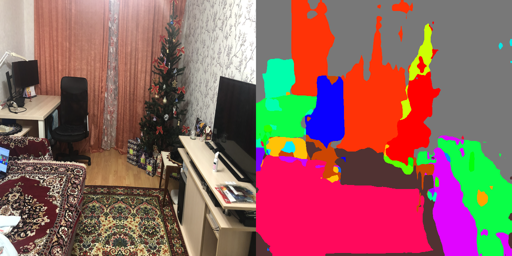

In [22]:
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original, pred)

In [23]:
pred

array([[ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [ 3,  3,  3, ..., 10, 10, 10],
       [ 3,  3,  3, ..., 10, 10, 10],
       [ 3,  3,  3, ..., 10, 10, 10]])

## Showing classes individually

To see which colors are which, here we visualize individual classes, one at a time.

In [25]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
predicted_classes

array([  0,  28,  18,  33,   3,  10,  66,  75,  74,  19,  17,  39, 112,
        67, 141,   7,  98,  57,  41, 137,   2,  71,  65,  70, 138,  23,
        24, 115,  22,  44,  40,  42, 132,  43,  38,  37,  36,  48,  45,
        46,  47,  34,  49,  50,  51,  52,  53,  54,  55,  56,  58,  35,
        29, 133,  15,   1, 139,   4,   5,   6,   8,   9,  11,  12,  13,
        14,  16,  32, 136, 135,  20,  21,  25,  26,  27, 134,  60,  30,
        31,  59, 126,  61,  94,  96,  97,  99, 100, 101, 102, 103, 104,
       105, 106, 107, 108, 109, 110, 111, 127, 113, 114, 116, 117, 118,
       119, 120, 121, 122, 123, 124,  95,  93,  62,  92, 125,  64, 131,
       130,  68,  69, 140,  72,  73, 129, 128,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  63])

wall:


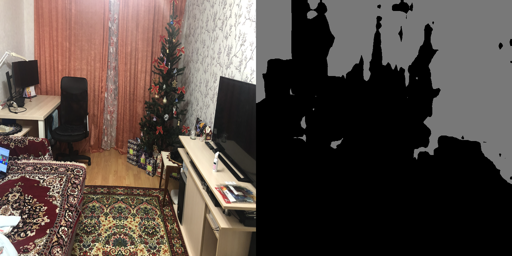

rug:


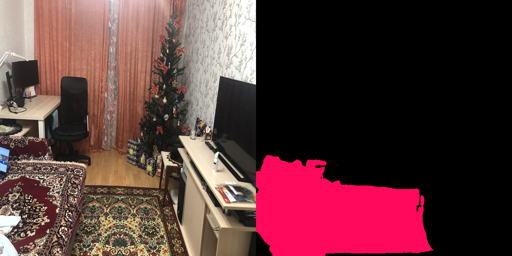

curtain:


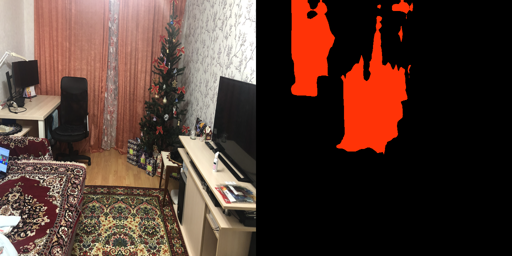

desk:


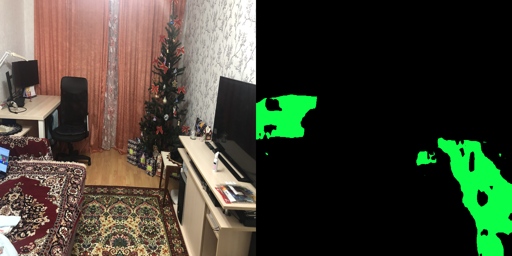

floor:


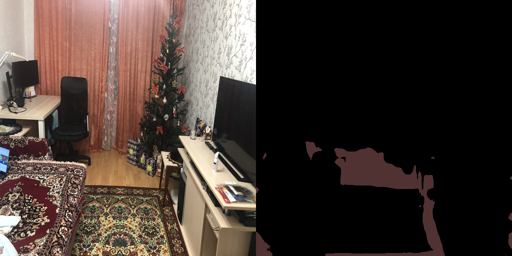

cabinet:


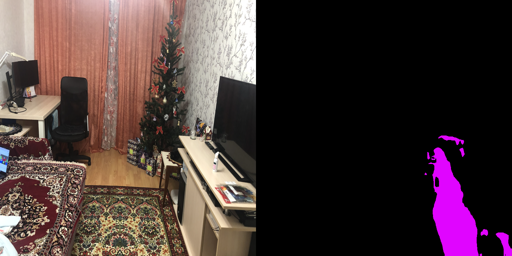

flower:


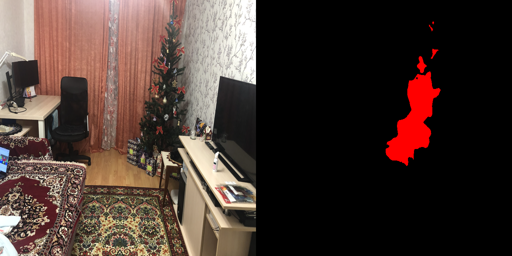

swivel:


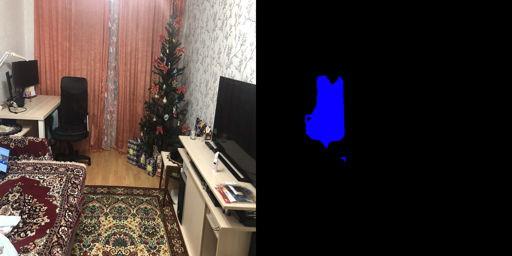

computer:


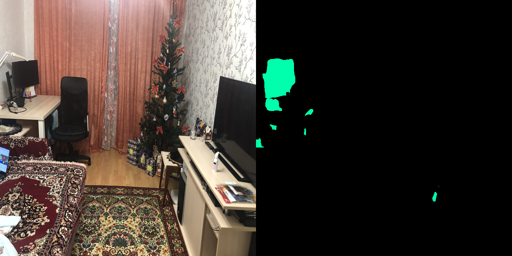

chair:


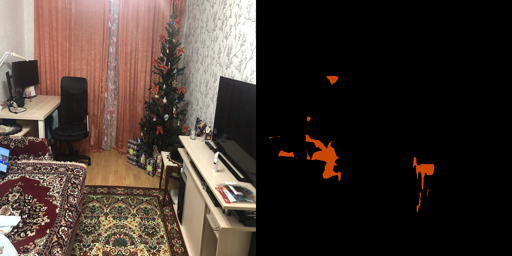

plant:


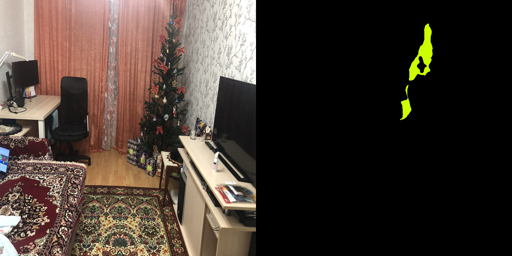

cushion:


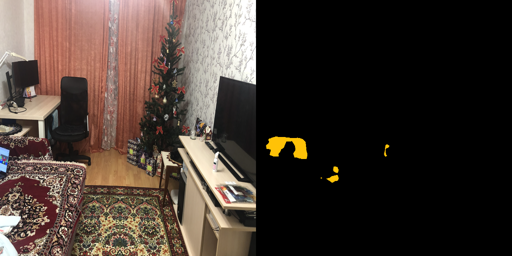

basket:


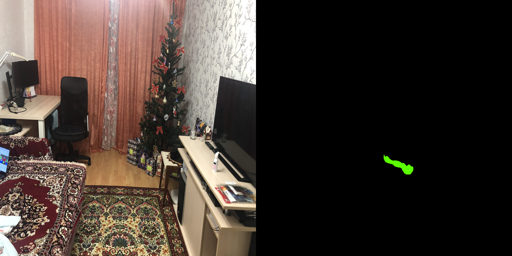

book:


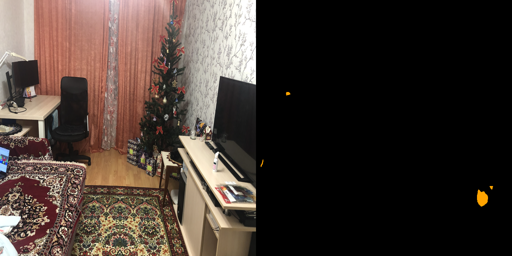

crt:


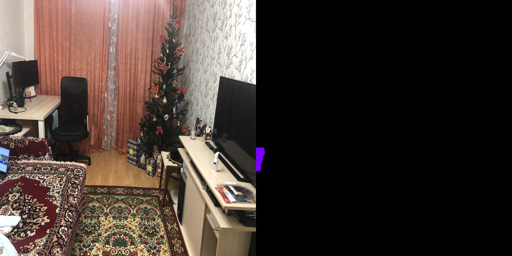

In [26]:
# Top classes in answer
predicted_classes = numpy.bincount(pred.flatten()).argsort()[::-1]
for c in predicted_classes[:15]:
    visualize_result(img_original, pred, c)